### 10(a) Run the following code to set up and get acquianted with a baseball team dataset. How many feature variables are there? What is the response/output variable?

In [1]:
# perform standard imports
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from operator import itemgetter

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

In [2]:
# categorical variables. See that lab for details...
hitters = pd.read_csv('Hitters.csv', index_col=0).dropna()

# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])

# Generate new dataframe with new dummy variables
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)

# add new dummy variables to hitters
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,True,True,True
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,False,True,False
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,True,False,True
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,True,False,True
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,False,True,False


#####  Meaning of features
At Bat 1986; 
 Hits 1986;
 Home Runs 1986;
 Runs 1986;
 RBI (runs batted in) 1986;
 Walks 1986;
 Years in major leagues;
 Career AtBat;
 Career Hits;
 Career Home Runs;
 Career Runs;
 Career RBI;
 Career Walks;
 Put Outs 1986;
 Assists 1986;
 Errors 1986
 ###### Salary 1987 annual salary on opening day in thousands of dollars

In [3]:
# Code for normalizing/standardizing data
def Normdata(X):
    Norm_X = X.copy()
    names = list(X)
    for i in names:
        Norm_X[i] = (X[i]-X[i].mean())/X[i].std()
    return Norm_X

Norm_hitters=Normdata(hitters)
hitters=Norm_hitters

# Get the predictors and response from hitters 
X = hitters.drop('Salary', axis = 1)
y = hitters.Salary

### 10(b) Run the code to do Ridge regression for a range of alpha (penalty).  SKLEARN.RIDGE minimizes:
$\min \left(\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\alpha\|\beta_j\|_2^2\right)$
###           We print 2 values of alpha and the corresponding l2 norms and construct a plot of the coefficients versus alpha. How is the l2 norm related to alpha?

sklearn alpha =  24.77076355991714
l2 norm of Betas= 0.5016676288406856 

sklearn alpha = 1.5199110829529332
l2 norm of Betas= 1.3231806117914264


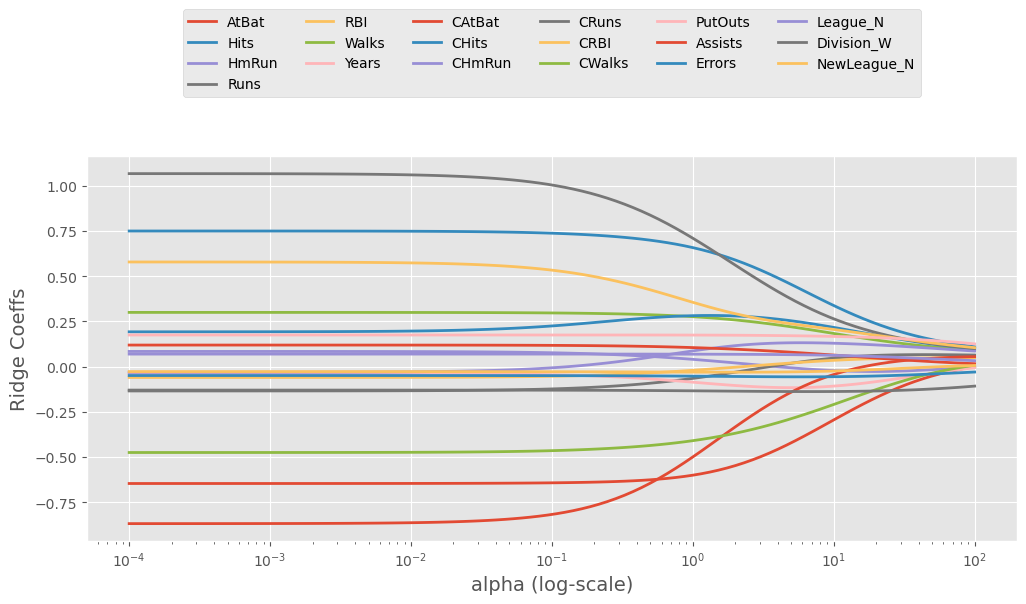

In [4]:
regr = [] # list to hold our regression models

alphas = 10**np.linspace(-4,2,100)  # generate different values of alphas and build models
for index, alph in enumerate(alphas):
    model = Ridge(alpha=alph, fit_intercept=True)
    regr = np.append(regr, model.fit(X,y))
    
df = pd.Series(data = np.hstack([regr[89].intercept_, regr[89].coef_]), index = ["Intercept"]+list(X.columns))
print('sklearn alpha = ', alphas[89])
print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])),'\n')

df = pd.Series(data = np.hstack([regr[69].intercept_, regr[69].coef_]), 
               index=['Intercept'] + X.columns.tolist())
print('sklearn alpha =', regr[69].alpha) 
print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

# We can make a plot of each of the ridge regression coeffecients as a function of the shrinkage factor alpha
ridge_coefs = np.empty((len(alphas),X.shape[1]))

# get the ridge coeffecients
for index, model in enumerate(regr):
    ridge_coefs[index] = model.coef_[np.newaxis]
    
# Construct plot    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(alphas,ridge_coefs, linewidth =2.0);
ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize=14)
ax.set_ylabel('Ridge Coeffs', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

### 10(c) We will use cross validation to find the best alpha (with the lowest MSE) in Ridge regression, run the code, what is the best alpha?

Min Alpha, Min CV =  3.0538555088334185 0.560725414727298


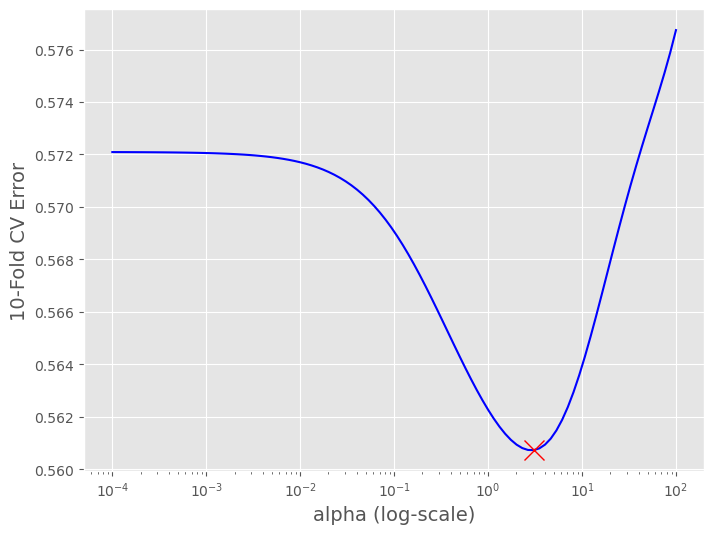

In [5]:
# Cross Validation Approach to Determine Best Alpha #
#####################################################
# scikit learns RidgeCV does not return cross-validation MSEs except for LOOCV case so we will custom write
# the cross validation procedure...

alphas = 10**np.linspace(-4,2, 100)

# construct training and test folds
#kf = KFold(len(X), n_folds=10)
 
kf = KFold(n_splits=10)
kf.get_n_splits(X)
     
cvs = []

for alpha in alphas:
    # For each shrinkage factor compute the models MSE for the 10-folds
    error = []
    
    for train, test in kf.split(X):
        # get test/train splits
        X_train = X.values[train]
        y_train = y.values[train]
        X_test = X.values[test]
        y_test = y.values[test]
        
        # build model for each split
        # model = Ridge(alpha=alpha, normalize=True).fit(X_train,y_train)
        model = Ridge(alpha=alpha).fit(X_train,y_train)
        # compute error for this each response at this alpha for this fold
        error = np.append(error,(model.predict(X_test)-y_test))
        
    # compute mean squared error for this alpha
    cvs = np.append(cvs,np.mean(error**2))

# get the minimum alpha
min_index, min_cvs = min(enumerate(cvs), key=itemgetter(1)) 
print('Min Alpha, Min CV = ', alphas[min_index], min_cvs)

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(alphas, cvs, color='b')
ax.plot(alphas[min_index], min_cvs, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);

### 10(d) Run the code to do Lasso regression for a range of alpha (penalty). Scikit Learn's Lasso method minimizes the following objective function:
$\min \left((1/2N)\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\alpha\|\beta_j\|_1\right)$
### We plot the coefficients versus alpha and print the coefficients corresponding to two values of alpha, which features have been eliminated at the higher value of alpha?

alpha: 0.0004037017258596554
[-0.62859215  1.02667205  0.2187398  -0.26967109 -0.13251503  0.16554924
  0.08026988 -0.34547931 -0.7723816   0.33830564  1.59482588  0.00994776
 -0.38107269  0.17884231  0.03265923  0.06592084  0.18284909 -0.04938946
 -0.11332268]
alpha: 0.10722672220103231
[ 0.          0.09230631  0.02745346  0.06868279  0.11940868  0.
  0.          0.          0.          0.0395845   0.30288418  0.
  0.          0.07552587 -0.          0.          0.         -0.
 -0.        ]


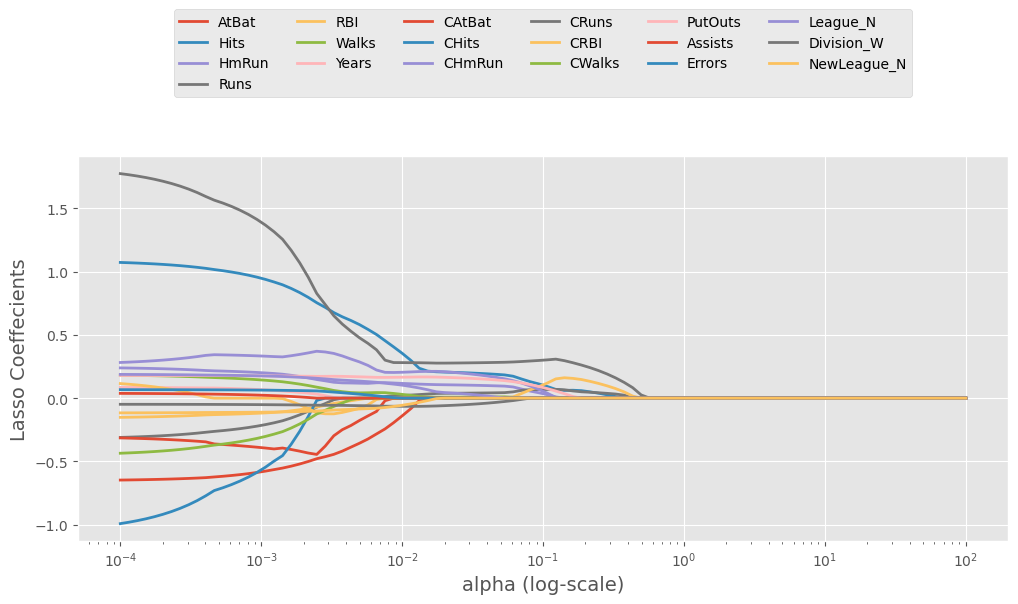

In [6]:
grid = 10**np.linspace(-4,2,100)  # set the values of alpha

np.random.seed(0)
train = np.random.choice([True, False], size=len(hitters)) # split the data into test and validation sets

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

coefficients = np.empty((len(grid),X.shape[1]))

for index, alpha in enumerate(grid):
    # create model with normalize = False
    # lasso = Lasso(alpha=alpha, normalize=True, max_iter=10000)
    lasso = Lasso(alpha=alpha, max_iter=10000)
    
    # I made a pipeline so that later if I can hunt down the scaling 
    # problems I can easily include a transform of the predictors
    pipeline = Pipeline([('lasso', lasso)])
    
    # fit scaled training data model
    pipeline.fit(X_train, y_train)
    
    coefficients[index] = lasso.coef_[np.newaxis]
    
print("alpha:", grid[10])
print(coefficients[10])
print("alpha:", grid[50])
print(coefficients[50])

# Make a plot of the coefficients   
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(grid, coefficients, linewidth =2.0);

ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize=14)
ax.set_ylabel('Lasso Coeffecients', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

### 10(e) We will use cross validation to find the best alpha (with the lowest error) in lasso regression, run the code, what is the best alpha?

Min Alpha =  0.05336699231206313


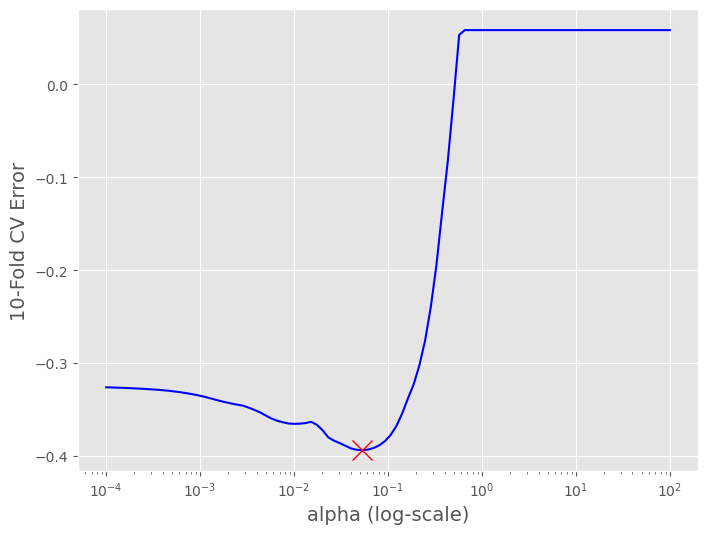

In [7]:
# Cross Validation to determine Optimum Alpha #
###############################################
scores = list()
np.random.seed(0)

# compute cross validation using MSE scoring
for alpha in grid:
    # for each alpha make a new model
    # lasso = Lasso(alpha=alpha, normalize=True, max_iter=10000)
    lasso = Lasso(alpha=alpha, max_iter=10000)
    # create our pipeline for later potential scaling of predictors
    pipeline = Pipeline([('lasso', lasso)])
    
    # get the cross-val score
    this_scores = -cross_val_score(pipeline, X, y, cv=10)
    scores.append(np.mean(this_scores))
    
# get the minimum alpha
min_index, min_score = min(enumerate(scores), key=itemgetter(1))
print('Min Alpha = ', grid[min_index])

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(grid, scores, color='b')
ax.plot(grid[min_index], min_score, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);